In [1]:
# | hide
# from chewc.core import *
# from chewc.pop import *
# from chewc.sp import *
# from chewc.trait import *

# chewc

> JAX breeding sim

## Developer Guide

If you are new to using `nbdev` here are some useful pointers to get you started.

### Install chewc in Development mode

```sh
# make sure chewc package is installed in development mode
$ pip install -e .

# make changes under nbs/ directory
# ...

# compile to have changes apply to chewc
$ nbdev_prepare
```

## Usage

### Installation

Install latest from the GitHub [repository][repo]:

```sh
$ pip install git+https://github.com/cjGO/chewc.git
```


[repo]: https://github.com/cjGO/chewc
[docs]: https://cjGO.github.io/chewc/
[pypi]: https://pypi.org/project/chewc/
[conda]: https://anaconda.org/cjGO/chewc

### Documentation

Documentation can be found hosted on this GitHub [repository][repo]'s [pages][docs].

[repo]: https://github.com/cjGO/chewc
[docs]: https://cjGO.github.io/chewc/

## How to use

In [2]:
import jax
import jax.numpy as jnp
import time

# --- 1. JAX Setup ---
key = jax.random.PRNGKey(42)

# --- 2. Imports from the 'chewc' library ---
from chewc.sp import SimParam
from chewc.population import Population, quick_haplo
from chewc.trait import add_trait_a
from chewc.burnin import run_burnin
# Import the generation runner
from chewc.pipe import run_generation 

# --- 3. Define Genome Blueprint ---
n_chr, n_loci_per_chr, ploidy = 3, 100, 2
gen_map = jnp.array([jnp.linspace(0, 1, n_loci_per_chr) for _ in range(n_chr)])
centromeres = jnp.full(n_chr, 0.5)

# --- 4. Define Trait Architecture ---
trait_mean = 0.0
trait_var = 1.0
trait_h2 = 0.05

# --- 5. Define Burn-in Parameters ---
n_parents_select = 6
n_progeny = 20
burn_in_generations = 50

# --- 6. Instantiate SimParam ---
sp = SimParam(gen_map=gen_map, centromere=centromeres, ploidy=ploidy)

# --- 7. Create Founder Population ---
key, pop_key = jax.random.split(key)
founder_pop = quick_haplo(key=pop_key, sim_param=sp, n_ind=10, inbred=False)
sp = sp.replace(founderPop=founder_pop)

# --- 8. Add Trait to SimParam ---
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    sim_param=sp,
    n_qtl_per_chr=100,
    mean=jnp.array([trait_mean]),
    var=jnp.array([trait_var])
)

# --- 9. Run the entire Burn-in Phase with a single function call ---
key, burnin_key = jax.random.split(key)
h2 = jnp.array([trait_h2])

start_time = time.time()
final_pop = run_burnin(
    key=burnin_key,
    sp=sp,
    n_generations=burn_in_generations,
    n_parents=n_parents_select,
    n_progeny=n_progeny,
    h2=h2,
    verbose=True 
)
final_pop.geno.block_until_ready()
end_time = time.time()

# --- 10. Report Results ---
total_time = end_time - start_time
avg_time_per_gen = total_time / burn_in_generations

print("-" * 50)
print(f"Total simulation time for burn-in: {total_time:.4f} seconds.")
print(f"Average time per generation (including compilation): {avg_time_per_gen * 1000:.4f} ms")
print(f"\nFinal population state after {burn_in_generations} generations:")
print(final_pop)

# --- 11. Create a new generation from the final population ---
print("\n" + "-" * 50)
print("Running one more generation with all parents...")

# Create a new key for the next generation
key, next_gen_key = jax.random.split(key)

# All individuals in `final_pop` will be parents
n_all_parents = final_pop.nInd 
n_new_progeny = 2000

# Run a single generation
expanded_pop = run_generation(
    key=next_gen_key,
    pop=final_pop,
    h2=h2,
    n_parents=n_all_parents,
    n_crosses=n_new_progeny,
    use_pheno_selection=True, # Selection strategy doesn't matter here
    select_top_parents=True,  # since we use all parents.
    ploidy=sp.ploidy,
    gen_map=sp.gen_map,
    recomb_param_v=sp.recomb_params[0],
    traits=sp.traits
)
expanded_pop.geno.block_until_ready()

print(f"\nCreated new expanded population of {n_new_progeny} individuals:")
print(expanded_pop)

--- Starting Accelerated Burn-in (50 Generations) ---
Generation  1/50 | Mean Phenotype: 0.4809
Generation  2/50 | Mean Phenotype: 0.2831
Generation  3/50 | Mean Phenotype: 0.9954
Generation  4/50 | Mean Phenotype: 1.6294
Generation  5/50 | Mean Phenotype: 0.7427
Generation  6/50 | Mean Phenotype: 0.3273
Generation  7/50 | Mean Phenotype: 1.8350
Generation  8/50 | Mean Phenotype: 1.5327
Generation  9/50 | Mean Phenotype: 1.9929
Generation 10/50 | Mean Phenotype: 1.4055
Generation 11/50 | Mean Phenotype: 1.5754
Generation 12/50 | Mean Phenotype: 1.1933
Generation 13/50 | Mean Phenotype: 2.1454
Generation 14/50 | Mean Phenotype: 2.0374
Generation 15/50 | Mean Phenotype: 2.5389
Generation 16/50 | Mean Phenotype: 2.5578
Generation 17/50 | Mean Phenotype: 2.8936
Generation 18/50 | Mean Phenotype: 2.2968
Generation 19/50 | Mean Phenotype: 2.1544
Generation 20/50 | Mean Phenotype: 2.1854
Generation 21/50 | Mean Phenotype: 2.7047
Generation 22/50 | Mean Phenotype: 2.3329
Generation 23/50 | Mea

(array([  3.,  31., 117., 402., 578., 487., 279.,  85.,  15.,   3.]),
 array([1.53299987, 1.81443071, 2.09586167, 2.37729263, 2.65872335,
        2.94015408, 3.22158527, 3.503016  , 3.78444672, 4.06587791,
        4.34730864]),
 <BarContainer object of 10 artists>)

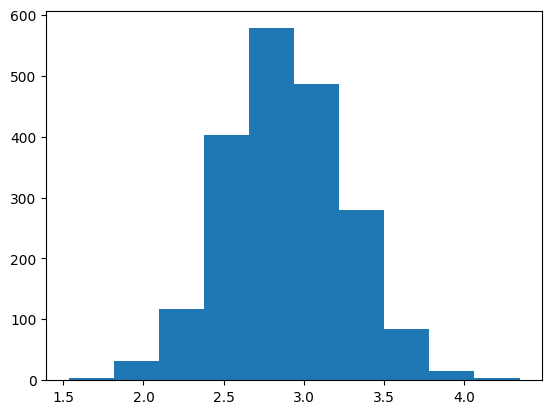

In [3]:
import matplotlib.pyplot as plt
plt.hist(expanded_pop.pheno)

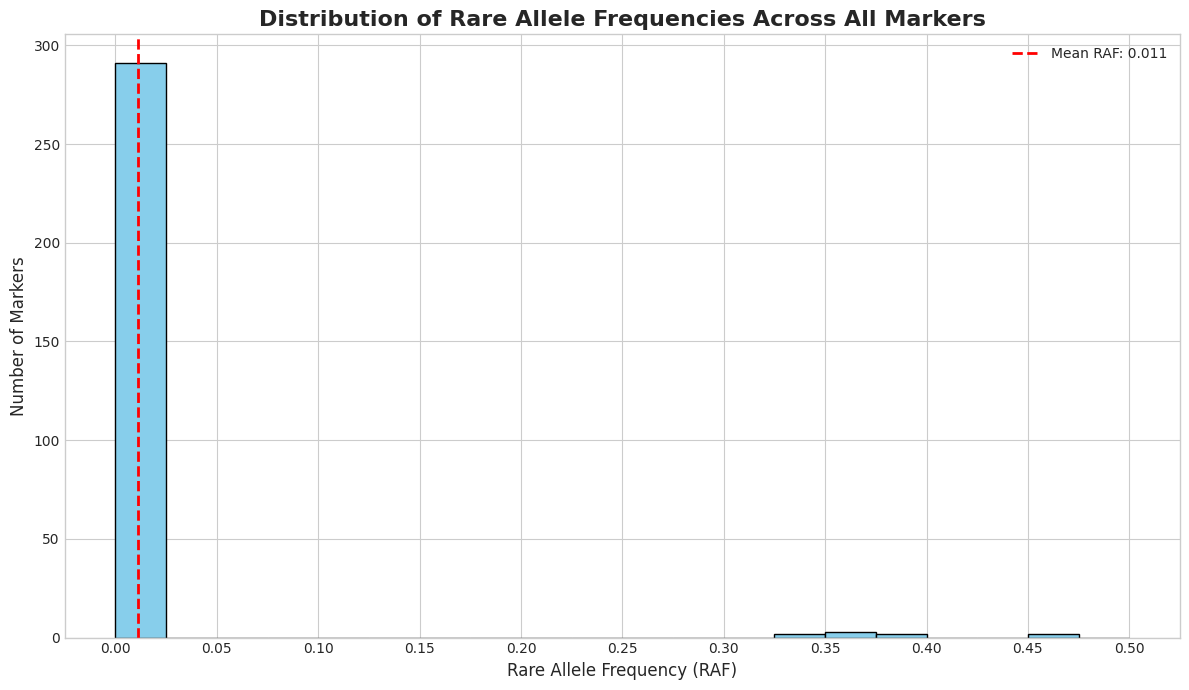

Shape of the summary array: (3, 100)
Shape of the flattened array for plotting: (300,)
Mean Rare Allele Frequency: 0.011166666634380817
Min Frequency: 0.0
Max Frequency: 0.44999998807907104
Shape of the input data: (2000, 3, 2, 100)
Shape of the final summary array: (3, 100)

Example: Proportions for the first 5 markers on the first chromosome:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [4]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np

# 1. Simulate your data array
# This creates a random array with the specified dimensions to demonstrate the logic.
# Shape: (individuals, chromosomes, haplotypes, markers)
key = random.PRNGKey(42)
def calculate_rare_allele_frequency(data):
  """
  Calculates the proportion of the rare allele for each marker per chromosome.

  Args:
    data: A jnp.ndarray with shape (individuals, chromosomes, haplotypes, markers).

  Returns:
    A jnp.ndarray with shape (chromosomes, markers) containing the rare allele proportions.
  """
  # Total alleles per marker = number of individuals * number of haplotypes
  total_alleles = data.shape[0] * data.shape[2] # 100 * 2 = 200

  # Sum over the 'individuals' (axis 0) and 'haplotypes' (axis 2) dimensions.
  allele_1_counts = data.sum(axis=(0, 2))

  # Calculate the frequency (proportion) of allele '1'.
  p = allele_1_counts / total_alleles

  # The rare allele is the one with a frequency < 0.5.
  rare_allele_proportions = jnp.minimum(p, 1 - p)

  return rare_allele_proportions

# Get the (3, 100) summary array
rare_allele_summary = calculate_rare_allele_frequency(final_pop.geno)


# --- 2. Visualize the Frequencies as a Histogram ---

# Flatten the (3, 100) array into a 1D array of 300 values
# Convert to a standard NumPy array for plotting
frequencies_flat = np.array(rare_allele_summary.flatten())

# Create the histogram
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style for the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the histogram with 20 bins for good resolution
# The range is [0, 0.5] since these are rare allele frequencies
ax.hist(frequencies_flat, bins=20, range=(0, 0.5), color='skyblue', edgecolor='black')

# Set titles and labels for clarity
ax.set_title('Distribution of Rare Allele Frequencies Across All Markers', fontsize=16, fontweight='bold')
ax.set_xlabel('Rare Allele Frequency (RAF)', fontsize=12)
ax.set_ylabel('Number of Markers', fontsize=12)

# Set x-axis ticks for better readability
ax.set_xticks(np.arange(0, 0.51, 0.05))

# Add a vertical line at the mean RAF
mean_raf = frequencies_flat.mean()
ax.axvline(mean_raf, color='red', linestyle='--', linewidth=2, label=f'Mean RAF: {mean_raf:.3f}')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

# --- Verification ---
print(f"Shape of the summary array: {rare_allele_summary.shape}")
print(f"Shape of the flattened array for plotting: {frequencies_flat.shape}")
print(f"Mean Rare Allele Frequency: {mean_raf}")
print(f"Min Frequency: {frequencies_flat.min()}")
print(f"Max Frequency: {frequencies_flat.max()}")

# 3. Get the final result
rare_allele_summary = calculate_rare_allele_frequency(expanded_pop.geno)

# --- Verification ---
print(f"Shape of the input data: {expanded_pop.geno.shape}")
print(f"Shape of the final summary array: {rare_allele_summary.shape}")
print("\nExample: Proportions for the first 5 markers on the first chromosome:")
print(rare_allele_summary[1, :100])

In [5]:
import gymnasium as gym
from gymnasium import spaces
import jax
import jax.numpy as jnp
import numpy as np
from typing import Dict, Any, Optional, Tuple

# --- Imports from your codebase ---
# These are assumed to be in an installable package named 'chewc'
from chewc.population import Population, quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import _make_cross_geno # We need the JIT-compiled core function

class BreedingEnv(gym.Env):
    """
    A Gymnasium environment for a simulated breeding program.

    The agent's goal is to maximize the genetic merit of a population over
    a series of generations by selecting the best parents.

    **Observation Space:**
    A dictionary containing the phenotypic and true breeding values of the
    current population.
    - `phenotypes`: Box(shape=(pop_size, n_traits))
    - `breeding_values`: Box(shape=(pop_size, n_traits))

    **Action Space:**
    A `MultiDiscrete` space where the agent selects a fixed number of
    individuals from the current population to be parents. The action is an
    array of integer indices.
    - `MultiDiscrete([pop_size] * n_parents_to_select)`

    **Reward:**
    The reward at each step is the change in the mean breeding value of the
    population from the previous generation to the current one. This directly
    incentivizes genetic gain.

    **Termination/Truncation:**
    - The episode is `truncated` after a maximum number of generations is reached.
    - The episode is `terminated` if the genetic variance of the population
      drops below a threshold, indicating that no further progress can be made.
    """
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, env_config: Dict[str, Any]):
        """
        Initializes the breeding environment.

        Args:
            env_config (Dict[str, Any]): A dictionary containing configuration
                parameters for the simulation. Expected keys are:
                - `pop_size`: The number of individuals in the population each generation.
                - `n_parents_to_select`: The number of parents the agent must select.
                - `n_traits`: The number of traits to simulate.
                - `n_chr`: The number of chromosomes.
                - `n_loci_per_chr`: The number of loci on each chromosome.
                - `ploidy`: The ploidy of the individuals (e.g., 2 for diploid).
                - `trait_mean`: The target mean for the trait(s).
                - `trait_var`: The target variance for the trait(s).
                - `h2`: The narrow-sense heritability of the trait(s).
                - `max_generations`: The maximum number of generations per episode.
                - `termination_var_threshold`: Genetic variance level to terminate episode.
        """
        super().__init__()
        self.config = env_config
        self.state: Dict[str, Any] = {}

        # --- Define Observation and Action Spaces ---
        pop_size = self.config['pop_size']
        n_traits = self.config['n_traits']
        n_parents = self.config['n_parents_to_select']

        self.observation_space = spaces.Dict({
            "phenotypes": spaces.Box(low=-np.inf, high=np.inf, shape=(pop_size, n_traits), dtype=np.float32),
            "breeding_values": spaces.Box(low=-np.inf, high=np.inf, shape=(pop_size, n_traits), dtype=np.float32)
        })

        # The action is to select `n_parents` individuals from the population of `pop_size`
        self.action_space = spaces.MultiDiscrete(np.full(n_parents, pop_size))

    def _get_obs(self) -> Dict[str, np.ndarray]:
        """Constructs the observation dictionary from the current population state."""
        pop = self.state['population']
        return {
            "phenotypes": np.array(pop.pheno),
            "breeding_values": np.array(pop.bv)
        }

    def _get_info(self) -> Dict[str, Any]:
        """Constructs the info dictionary with useful metrics."""
        pop = self.state['population']
        mean_bv = jnp.mean(pop.bv, axis=0)
        var_bv = jnp.var(pop.bv, axis=0)
        return {
            "generation": self.state['generation'],
            "mean_bv": np.array(mean_bv),
            "var_bv": np.array(var_bv)
        }

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[Dict, Dict]:
        """
        Resets the environment to an initial state, creating a new founder population.
        """
        super().reset(seed=seed)
        # Derive a JAX key from the gym-managed seed
        key_seed = self.np_random.integers(0, 2**32 - 1)
        self.state['key'] = jax.random.PRNGKey(key_seed)

        # --- Create Simulation Parameters (SimParam) ---
        key, sp_key = jax.random.split(self.state['key'])
        self.state['key'] = key

        # For simplicity, create a uniform genetic map
        gen_map = jnp.stack([
            jnp.linspace(0, 1.0, self.config['n_loci_per_chr'])
            for _ in range(self.config['n_chr'])
        ])

        sp = SimParam(
            gen_map=gen_map,
            centromere=jnp.zeros(self.config['n_chr']), # Placeholder
            ploidy=self.config['ploidy']
        )

        # --- Create Founder Population ---
        key, pop_key, trait_key, pheno_key = jax.random.split(sp_key, 4)
        founder_pop = quick_haplo(pop_key, sp, n_ind=self.config['pop_size'])
        sp = sp.replace(founderPop=founder_pop) # Attach founder pop to sp for trait setup

        # --- Add Genetic Architecture for Traits ---
        sp = add_trait_a(
            trait_key,
            sp,
            n_qtl_per_chr=self.config['n_loci_per_chr'] // 2, # Use half of loci as QTLs
            mean=jnp.full(self.config['n_traits'], self.config['trait_mean']),
            var=jnp.full(self.config['n_traits'], self.config['trait_var'])
        )

        # --- Set Initial Phenotypes ---
        initial_pop = set_pheno(
            pheno_key,
            founder_pop,
            sp.traits,
            sp.ploidy,
            h2=jnp.full(self.config['n_traits'], self.config['h2'])
        )

        self.state['population'] = initial_pop
        self.state['sim_param'] = sp
        self.state['generation'] = 0

        return self._get_obs(), self._get_info()

    def step(self, action: np.ndarray) -> Tuple[Dict, float, bool, bool, Dict]:
        """
        Advances the environment by one generation.

        The agent's action determines which parents are selected. The environment
        then handles crossing them to produce the next generation.
        """
        # 1. Get current state
        current_pop = self.state['population']
        sp = self.state['sim_param']
        self.state['generation'] += 1

        # 2. Split JAX key for this generation's random operations
        keys = jax.random.split(self.state['key'], 5)
        self.state['key'], key_cross_plan, key_cross_geno, key_pheno, key_sex = keys

        # 3. Use the agent's action to define the parent pool
        parent_indices = jnp.array(action, dtype=jnp.int32)

        # 4. Create a random cross plan from the selected parents
        n_parents_selected = len(parent_indices)
        n_crosses = self.config['pop_size']

        mother_pool_indices = jax.random.choice(key_cross_plan, n_parents_selected, shape=(n_crosses,))
        key_cross_plan, _ = jax.random.split(key_cross_plan)
        father_pool_indices = jax.random.choice(key_cross_plan, n_parents_selected, shape=(n_crosses,))

        mother_iids = parent_indices[mother_pool_indices]
        father_iids = parent_indices[father_pool_indices]

        # 5. Gather parent genotypes and public IDs for pedigree
        mothers_geno = current_pop.geno[mother_iids]
        fathers_geno = current_pop.geno[father_iids]
        mother_public_ids = current_pop.id[mother_iids]
        father_public_ids = current_pop.id[father_iids]

        # 6. Create progeny genotypes using the JIT-compiled core function
        progeny_geno = _make_cross_geno(
            key_cross_geno,
            mothers_geno,
            fathers_geno,
            sp.n_chr,
            sp.gen_map,
            sp.recomb_params[0]
        )

        # 7. Assemble the new population object
        next_id_start = current_pop.id.max() + 1
        progeny_pop_no_values = Population(
            geno=progeny_geno,
            id=jnp.arange(next_id_start, next_id_start + n_crosses),
            iid=jnp.arange(n_crosses),
            mother=mother_public_ids,
            father=father_public_ids,
            sex=jax.random.choice(key_sex, jnp.array([0, 1], dtype=jnp.int8), (n_crosses,)),
            pheno=jnp.zeros((n_crosses, sp.n_traits)),
            fixEff=jnp.zeros(n_crosses, dtype=jnp.float32),
            bv=jnp.zeros((n_crosses, sp.n_traits)),
        )

        # 8. Calculate BV and Phenotypes for the new generation
        new_pop = set_pheno(
            key_pheno,
            progeny_pop_no_values,
            sp.traits,
            sp.ploidy,
            h2=jnp.full(self.config['n_traits'], self.config['h2'])
        )

        # 9. Calculate reward as the change in mean breeding value
        reward = float(jnp.mean(new_pop.bv) - jnp.mean(current_pop.bv))

        # 10. Update state
        self.state['population'] = new_pop

        # 11. Check for termination and truncation
        genetic_variance = jnp.var(new_pop.bv)
        terminated = bool(genetic_variance < self.config['termination_var_threshold'])
        truncated = bool(self.state['generation'] >= self.config['max_generations'])

        # 12. Get observation and info for the next step
        obs = self._get_obs()
        info = self._get_info()

        return obs, reward, terminated, truncated, info

    def render(self):
        """Prints a summary of the current generation to the console."""
        if self.state:
            info = self._get_info()
            print(
                f"Generation: {info['generation']:<3} | "
                f"Mean BV: {info['mean_bv'][0]:<8.4f} | "
                f"Genetic Var: {info['var_bv'][0]:<8.4f}"
            )

    def close(self):
        """Cleans up any resources if needed."""
        pass

In [6]:
# Example configuration
env_config = {
    "pop_size": 50,
    "n_parents_to_select": 10,
    "n_traits": 1,
    "n_chr": 10,
    "n_loci_per_chr": 100,
    "ploidy": 2,
    "trait_mean": 100.0,
    "trait_var": 10.0,
    "h2": 0.3,
    "max_generations": 20,
    "termination_var_threshold": 1e-3,
}

In [7]:
# Assuming the BreedingEnv class is in a file named breeding_env.py
# from breeding_env import BreedingEnv

# Create the environment
env = BreedingEnv(env_config)

# Reset the environment to get the first observation
obs, info = env.reset(seed=42)
env.render()

# Run a few random steps
for i in range(env_config['max_generations']):
    action = env.action_space.sample()  # Take a random action
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()

    if terminated or truncated:
        print("Episode finished.")
        break

env.close()

Generation: 0   | Mean BV: -0.9388  | Genetic Var: 10.0000 
Generation: 1   | Mean BV: 0.1067   | Genetic Var: 6.3326  
Generation: 2   | Mean BV: -0.0977  | Genetic Var: 6.7266  
Generation: 3   | Mean BV: -0.0160  | Genetic Var: 5.4161  
Generation: 4   | Mean BV: -0.2494  | Genetic Var: 3.3485  
Generation: 5   | Mean BV: 0.0294   | Genetic Var: 5.8056  
Generation: 6   | Mean BV: 0.3175   | Genetic Var: 5.5736  
Generation: 7   | Mean BV: 0.6966   | Genetic Var: 5.0440  
Generation: 8   | Mean BV: -0.6258  | Genetic Var: 4.1926  
Generation: 9   | Mean BV: 0.3350   | Genetic Var: 2.6346  
Generation: 10  | Mean BV: 0.3420   | Genetic Var: 2.8810  
Generation: 11  | Mean BV: 0.0643   | Genetic Var: 3.8909  
Generation: 12  | Mean BV: 0.6937   | Genetic Var: 4.7144  
Generation: 13  | Mean BV: 2.3104   | Genetic Var: 3.3889  
Generation: 14  | Mean BV: 2.2896   | Genetic Var: 2.6752  
Generation: 15  | Mean BV: 2.5413   | Genetic Var: 3.3434  
Generation: 16  | Mean BV: 2.3482   | Ge

In [10]:
import gymnasium as gym
from gymnasium import spaces
import jax
import jax.numpy as jnp
import numpy as np
from typing import Dict, Any, Optional, Tuple

# --- Assumed imports from your chew_c package ---
from chewc.population import Population, quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import _make_cross_geno # The JIT-compiled core

class TruncationSelectionEnv(gym.Env):
    """
    A focused Gymnasium environment for Experiment 0: Replicating truncation selection.

    **MDP Formulation:**
    - **Observation (State):** Vector of true breeding values (BVs).
    - **Action:** A single scalar `p` representing the selection percentile.
    - **Reward:** The absolute mean BV of the next generation's population.
    """
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, env_config: Dict[str, Any]):
        """Initializes the environment using a configuration dictionary."""
        super().__init__()
        self.config = env_config
        self.state: Dict[str, Any] = {}

        pop_size = self.config['pop_size']
        n_traits = self.config['n_traits']

        ## MODIFICATION 1: Simplified Action Space ##
        # The action is a single float between 0.01 and 1.0 representing the percentile.
        self.action_space = spaces.Box(low=0.01, high=1.0, shape=(1,), dtype=np.float32)

        ## MODIFICATION 2: Simplified Observation Space ##
        # The observation is just the vector of BVs.
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(pop_size, n_traits), dtype=np.float32
        )

    def _get_obs(self) -> np.ndarray:
        """Returns the current observation (breeding values)."""
        return np.array(self.state['population'].bv)

    def _get_info(self) -> Dict[str, Any]:
        """Returns diagnostic information."""
        pop = self.state['population']
        return {
            "generation": self.state['generation'],
            "mean_bv": np.array(jnp.mean(pop.bv, axis=0)),
            "var_bv": np.array(jnp.var(pop.bv, axis=0))
        }

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict]:
        """Resets the environment and creates a new founder population."""
        super().reset(seed=seed)
        key_seed = self.np_random.integers(0, 2**32 - 1)
        self.state['key'] = jax.random.PRNGKey(key_seed)

        # This setup logic is excellent and can be reused directly from your guide
        key, sp_key = jax.random.split(self.state['key'])
        self.state['key'] = key
        gen_map = jnp.stack([jnp.linspace(0, 1.0, self.config['n_loci_per_chr']) for _ in range(self.config['n_chr'])])
        sp = SimParam(gen_map=gen_map, centromere=jnp.zeros(self.config['n_chr']), ploidy=self.config['ploidy'])
        
        key, pop_key, trait_key, pheno_key = jax.random.split(sp_key, 4)
        founder_pop = quick_haplo(pop_key, sp, n_ind=self.config['pop_size'])
        sp = sp.replace(founderPop=founder_pop)
        
        sp = add_trait_a(
            trait_key, sp, n_qtl_per_chr=self.config['n_loci_per_chr'] // 2,
            mean=jnp.full(self.config['n_traits'], self.config['trait_mean']),
            var=jnp.full(self.config['n_traits'], self.config['trait_var'])
        )
        
        initial_pop = set_pheno(
            pheno_key, founder_pop, sp.traits, sp.ploidy,
            h2=jnp.full(self.config['n_traits'], self.config['h2'])
        )
        
        self.state['population'] = initial_pop
        self.state['sim_param'] = sp
        self.state['generation'] = 0
        
        return self._get_obs(), self._get_info()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """Advance one generation using truncation selection based on the action `p`."""
        current_pop = self.state['population']
        sp = self.state['sim_param']
        
        keys = jax.random.split(self.state['key'], 4)
        self.state['key'], key_cross_plan, key_cross_geno, key_pheno = keys

        ## MODIFICATION 3: Action Determines Selection Pressure ##
        selection_percentile = action[0]
        n_select = int(np.ceil(self.config['pop_size'] * selection_percentile))
        
        # Ensure an even number for pairing
        if n_select % 2 != 0:
            n_select = np.clip(n_select + 1, 2, self.config['pop_size'])
            
        indices = jnp.argsort(current_pop.bv.flatten()) # Flatten for single trait
        selected_parent_iids = indices[-n_select:]

        # Create a random cross plan from the selected parents
        n_crosses = self.config['pop_size']
        mother_pool_indices = jax.random.choice(key_cross_plan, n_select, shape=(n_crosses,))
        key_cross_plan, _ = jax.random.split(key_cross_plan)
        father_pool_indices = jax.random.choice(key_cross_plan, n_select, shape=(n_crosses,))
        
        mother_iids = selected_parent_iids[mother_pool_indices]
        father_iids = selected_parent_iids[father_pool_indices]
        
        # --- The rest is the ChewC simulation pipeline, which works perfectly ---
        mothers_geno = current_pop.geno[mother_iids]
        fathers_geno = current_pop.geno[father_iids]
        
        progeny_geno = _make_cross_geno(
            key_cross_geno, mothers_geno, fathers_geno, sp.n_chr,
            sp.gen_map, sp.recomb_params[0]
        )
        
        next_id_start = current_pop.id.max() + 1
        progeny_pop_no_values = Population.init_from_geno(progeny_geno, next_id_start) # Simplified init
        
        new_pop = set_pheno(
            key_pheno, progeny_pop_no_values, sp.traits, sp.ploidy,
            h2=jnp.full(self.config['n_traits'], self.config['h2'])
        )
        
        ## MODIFICATION 4: Reward is absolute mean BV of the next generation ##
        reward = float(jnp.mean(new_pop.bv))
        
        self.state['population'] = new_pop
        self.state['generation'] += 1
        
        ## MODIFICATION 5: Termination is based on max generations (truncation) ##
        terminated = False # No failure condition in this simple experiment
        truncated = bool(self.state['generation'] >= self.config['max_generations'])
        
        obs = self._get_obs()
        info = self._get_info()
        
        return obs, reward, terminated, truncated, info

    def render(self):
        """Prints a summary of the current generation."""
        info = self._get_info()
        print(f"Gen: {info['generation']:<3} | Mean BV: {info['mean_bv'][0]:<8.4f} | Var BV: {info['var_bv'][0]:<8.4f}")